# Task 1: Symbolic, Unconditioned Generation

### Imports

In [145]:
# !pip install miditok
# !pip install symusic
# !pip install glob
# !pip install torch
# !pip install pretty_midi
# !pip install midi2audio

import pretty_midi
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from miditok.pytorch_data import DatasetMIDI, DataCollator
import glob
from miditok import REMI, TokenizerConfig
from torch.utils.data import DataLoader
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
%matplotlib inline
import math


### Setup NES-MDB

In [ ]:
NESMDB_PATH = "./nesmdb_midi/"
midi_data = pretty_midi.PrettyMIDI(NESMDB_PATH + 'train/297_SkyKid_00_01StartMusicBGMIntroBGM.mid')

for instrument in midi_data.instruments:
  print('-' * 80)
  print(instrument.name.upper())
  print('# note events: {}'.format(len(instrument.notes)))
  print('# control change events: {}'.format(len(instrument.control_changes)))

Path to dataset files: /home/josh/.cache/kagglehub/datasets/imsparsh/lakh-midi-clean/versions/1
--------------------------------------------------------------------------------
P1
# note events: 158
# control change events: 221
--------------------------------------------------------------------------------
P2
# note events: 197
# control change events: 73
--------------------------------------------------------------------------------
TR
# note events: 123
# control change events: 0
--------------------------------------------------------------------------------
NO
# note events: 6
# control change events: 164


### Tokenizer and Datasets

In [ ]:
train_files = glob.glob(NESMDB_PATH + "train/*.mid")
test_files = glob.glob(NESMDB_PATH + "test/*.mid")

config = TokenizerConfig(
    use_time_signatures=True,
    use_tempos=True,
    use_programs=True,
    num_velocities=127,
    ac_polyphony_track = True,
    ac_polyphony_bar = True,
)

tokenizer = REMI(config)

train_dataset = DatasetMIDI(
    files_paths=train_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
    )
test_dataset = DatasetMIDI(
    files_paths=test_files,
    tokenizer=tokenizer,
    max_seq_len=1024,
    bos_token_id=tokenizer["BOS_None"],
    eos_token_id=tokenizer["EOS_None"],
)

/home/josh/miniconda3/envs/gpu-env/lib/python3.11/site-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


In [5]:
input_dir = "./nesmdb_midi/train/"
collator = DataCollator(tokenizer.pad_token_id)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=collator, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collator, num_workers=4)

In [6]:
len(train_loader), len(test_loader)

(1126, 94)

### Model: GRU

In [ ]:
class MusicGRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(MusicGRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.norm = nn.LayerNorm(embedding_dim)
        self.gru = nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        x = self.norm(self.embedding(x))  
        out, hidden = self.gru(x, hidden)
        out = self.fc(out)
        return out, hidden

#### Training

In [ ]:
from torch.amp import GradScaler, autocast

def train(model, train_loader, val_loader, vocab_size, num_epochs=10, lr=0.001, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.AdamW(model.parameters(), 3e-4, weight_decay=1e-2)
    scaler = GradScaler('cuda')

    for epoch in range(num_epochs):
        # Training
        model.train()
        total_train_loss = 0

        for batch in train_loader:
            batch = batch['input_ids'].to(device)  # (batch_size, seq_length)
            inputs = batch[:, :-1]
            targets = batch[:, 1:]

            optimizer.zero_grad()

            with autocast('cuda'):
                outputs, _ = model(inputs)
                outputs = outputs.reshape(-1, vocab_size)
                targets = targets.reshape(-1)
                loss = criterion(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        
        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch['input_ids'].to(device)

                inputs = batch[:, :-1]
                targets = batch[:, 1:]

                outputs, _ = model(inputs)
                outputs = outputs.reshape(-1, vocab_size)
                targets = targets.reshape(-1)

                loss = criterion(outputs, targets)
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")


if __name__ == "__main__":
    vocab_size = tokenizer.vocab_size
    embedding_dim = 128
    hidden_dim = 512
    num_layers = 2

    model = MusicGRU(vocab_size, embedding_dim, hidden_dim, num_layers)    
    train(model, train_loader, test_loader, vocab_size)

Epoch 1/10 | Train Loss: 2.4395 | Val Loss: 1.9650
Epoch 2/10 | Train Loss: 2.0247 | Val Loss: 1.8584
Epoch 3/10 | Train Loss: 1.9369 | Val Loss: 1.7829
Epoch 4/10 | Train Loss: 1.8575 | Val Loss: 1.7195
Epoch 5/10 | Train Loss: 1.7932 | Val Loss: 1.6797
Epoch 6/10 | Train Loss: 1.7512 | Val Loss: 1.6502
Epoch 7/10 | Train Loss: 1.7142 | Val Loss: 1.6344
Epoch 8/10 | Train Loss: 1.6886 | Val Loss: 1.6180
Epoch 9/10 | Train Loss: 1.6708 | Val Loss: 1.6053
Epoch 10/10 | Train Loss: 1.6510 | Val Loss: 1.5989


#### Sampling

In [76]:
def sample(model, start_token, max_length=100, temperature=0.8, device='cuda'):
    model = model.to(device)
    model.eval()

    generated = [start_token]
    input_token = torch.tensor([[start_token]], device=device)  # (1, 1)

    hidden = None

    for _ in range(max_length):
        output, hidden = model(input_token, hidden)  # output: (1, 1, vocab_size)
        output = output[:, -1, :]  # take the last output
        output = output / temperature  # adjust randomness

        probs = F.softmax(output, dim=-1)  # (1, vocab_size)
        next_token = torch.multinomial(probs, num_samples=1).item()
        generated.append(next_token)
        if next_token == 2 or next_token == 0: # reach end of sequence
          break

        input_token = torch.tensor([[next_token]], device=device)

    return generated

Generated token sequence:
[1, 4, 610, 284, 453, 553, 36, 107, 223, 554, 34, 107, 223, 511, 36, 93, 221, 288, 553, 36, 107, 221, 554, 35, 107, 221, 511, 36, 93, 221, 290, 553, 37, 107, 221, 554, 36, 107, 221, 511, 36, 93, 221, 293, 553, 38, 107, 221, 554, 35, 107, 221, 511, 38, 93, 221, 295, 553, 40, 107, 221, 554, 36, 107, 221, 511, 36, 93, 221, 297, 553, 45, 107, 221, 554, 398, 107, 221, 511, 37, 93, 221, 299, 553, 43, 107, 221, 554, 56, 107, 221, 511, 36, 93, 221, 301, 553, 43, 107, 221, 554, 57, 107, 221, 511, 91, 93, 220, 511, 40, 93, 221, 305, 553, 38, 107, 572, 554, 59, 107, 221, 511, 38, 93, 221, 307, 554, 59, 107, 221, 511, 34, 93, 221, 308, 554, 55, 107, 221, 511, 591, 93, 221, 310, 554, 57, 107, 221, 511, 34, 93, 221, 312, 554, 57, 107, 221, 511, 31, 93, 221, 314, 554, 62, 107, 221, 511, 27, 93, 221, 4, 610, 284, 554, 51, 107, 221, 511, 24, 93, 221, 286, 554, 47, 107, 221, 511, 27, 93, 221, 289, 554, 50, 107, 221, 511, 34, 93, 221, 290, 554, 41, 107, 221, 511, 117, 93, 221, 2

/tmp/ipykernel_3953/145865254.py:12: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  output_score = tokenizer.tokens_to_midi(generated_sequence)
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter 'FluidR3Mono_GM.sf3' not a SoundFont or MIDI file or error occurred identifying it.


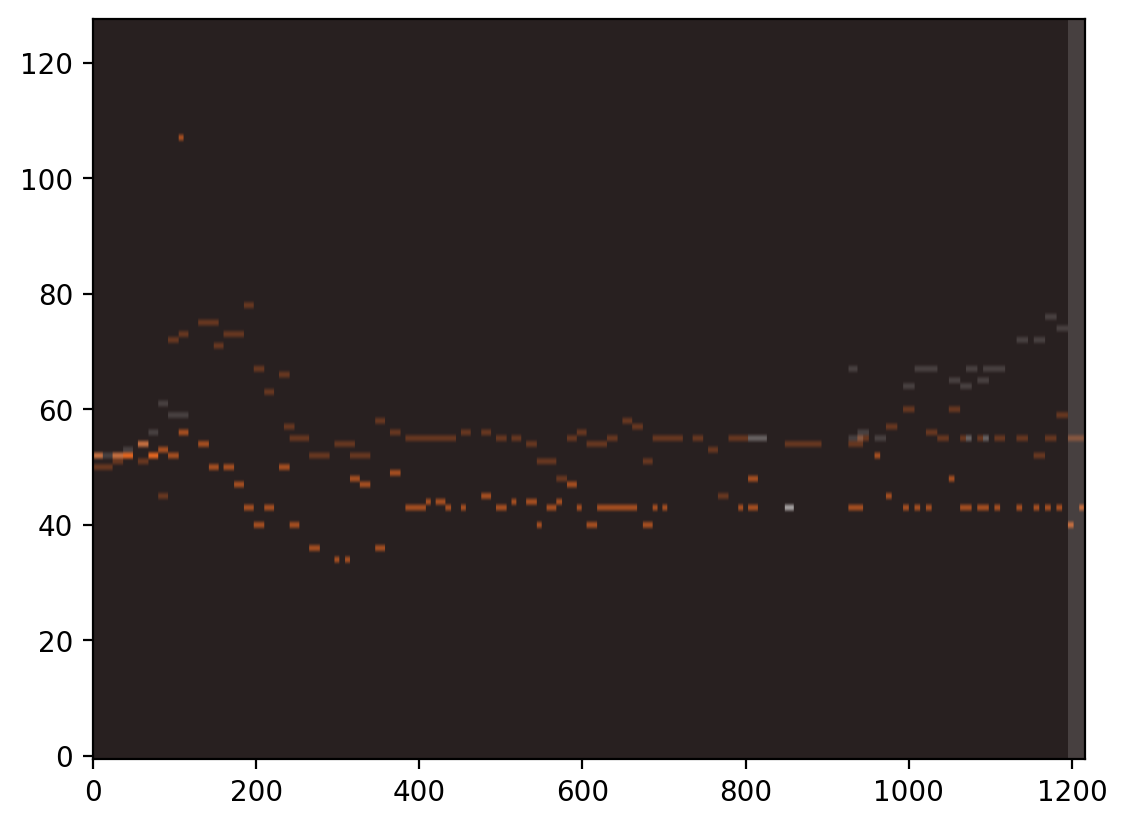

In [138]:
start_token = tokenizer.special_tokens_ids[1]
generated_sequence = sample(model, start_token, max_length=2048)

print("Generated token sequence:")
print(generated_sequence)

import midi2audio
from midi2audio import FluidSynth
from IPython.display import Audio, display
fs = FluidSynth("FluidR3Mono_GM.sf3")

output_score = tokenizer.tokens_to_midi(generated_sequence)
print(type(output_score))

# boost all note velocities
for track in output_score.tracks:
    for note in track.notes:
        note.velocity = min(127, max(60, int(note.velocity * 2)))

output_score.dump_midi(f"rnn.mid")
fs.midi_to_audio("rnn.mid", "rnn.wav")
display(Audio("rnn.wav"))
output_pm = pretty_midi.PrettyMIDI("rnn.mid")

for i, inst in enumerate(output_pm.instruments):
    pr = inst.get_piano_roll(fs=100)
    plt.imshow(pr, aspect='auto', origin='lower', alpha=0.5, cmap='hot')


In [147]:
train_loss = 1.6510
val_loss = 1.5989

train_perplexity = math.exp(train_loss)  # ≈ 5.21
val_perplexity = math.exp(val_loss)      # ≈ 4.95

print(f"Model Train Loss: {train_loss:.2f}")
print(f"Model Train Perplexity: {train_perplexity:.2f}")

print(f"Model Validation Loss: {val_loss:.2f}")
print(f"Model Validation Perplexity: {val_perplexity:.2f}")

Model Train Loss: 1.65
Model Train Perplexity: 5.21
Model Validation Loss: 1.60
Model Validation Perplexity: 4.95


### Evaluation: Random Token Generator

In [106]:
def generate_random_tokens(vocab_size, max_length=512):
    return torch.randint(low=0, high=vocab_size, size=(max_length,), dtype=torch.long).tolist()

def generate_random_sequence(tokenizer, max_length=512):
    vocab_size = tokenizer.vocab_size
    forbidden = {tokenizer["PAD_None"], tokenizer["EOS_None"]}

    random_tokens = []
    while len(random_tokens) < max_length - 1:
        token = torch.randint(0, vocab_size, (1,)).item()
        if token not in forbidden:
            random_tokens.append(token)

    return [tokenizer["BOS_None"]] + random_tokens

FluidSynth runtime version 2.3.4
Copyright (C) 2000-2023 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.

Rendering audio to file 'rando.wav'..


/tmp/ipykernel_3953/197685182.py:2: UserWarning: miditok: The `tokens_to_midi` method had been renamed `decode`. It is now depreciated and will be removed in future updates.
  rand_score = tokenizer.tokens_to_midi(random_tokens)
fluidsynth: error: fluid_is_soundfont(): fopen() failed: 'File does not exist.'
Parameter 'FluidR3Mono_GM.sf3' not a SoundFont or MIDI file or error occurred identifying it.


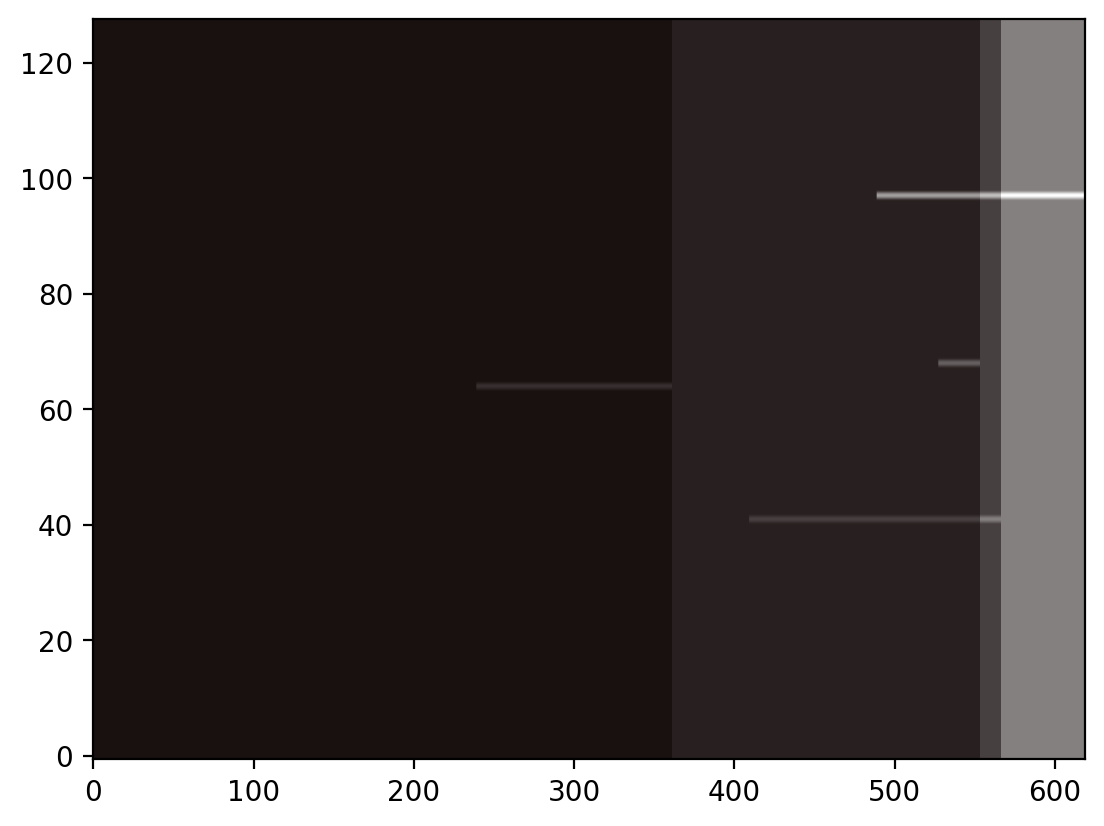

In [140]:
random_tokens = generate_random_sequence(tokenizer, max_length=512)
rand_score = tokenizer.tokens_to_midi(random_tokens)

# boost all note velocities
for track in rand_score.tracks:
    for note in track.notes:
        note.velocity = min(127, max(60, int(note.velocity * 2)))
rand_score.dump_midi(f"rando.mid")

fs.midi_to_audio("rando.mid", "rando.wav")
display(Audio("rando.wav"))

rand_pm = pretty_midi.PrettyMIDI("rando.mid")

for i, inst in enumerate(rand_pm.instruments):
    pr = inst.get_piano_roll(fs=100)
    plt.imshow(pr, aspect='auto', origin='lower', alpha=0.5, cmap='hot')


### Baseline

In [ ]:
baseline_vocab = [i for i in range(vocab_size) if i not in [tokenizer["PAD_None"], tokenizer["EOS_None"]]]
V = len(baseline_vocab)
uniform_crossentropyloss = math.log(V)
uniform_perplexity = math.exp(uniform_crossentropyloss)

print(f"Baseline Loss: {uniform_crossentropyloss:.2f}")
print(f"Baseline Perplexity: {uniform_perplexity:.2f}")

Baseline Loss: 6.41
Baseline Perplexity: 609.00


# Task 2: Continuous, Unconditioned Generation

## Imports

In [ ]:
## Pyotrch modules
import torch
from torch import nn
import torch.optim
import torchaudio
import torch.nn.functional as F
import pytorch_lightning as pl
import lightning as L
## basic libraries
import numpy as np
import matplotlib.pyplot as plt
## for display purposes
from tqdm.auto import trange, tqdm 
import IPython.display as ipd 
## for basic tensor operations
from einops import rearrange
## to read and display wav files
import glob
import librosa
import librosa.display
import soundfile as sf
## Mamba library
from mamba_ssm import Mamba
## custom dataloader for the data
from dataloader import AudioLoader, extract_waveform

## Model: SeSaMe

In [ ]:
class SeSaMe(nn.Module):
    def __init__(self,H=1,L=8000):
        super().__init__()
        ## Linear layers
        self.l1 = nn.Linear(4*H, 2*H)
        self.l2 = nn.Linear(8*H, 4*H)
        self.l3 = nn.Linear(4*H, 8*H)
        self.l4 = nn.Linear(2*H, 4*H)
        ## Mamba blocks
        self.mamba1 = Mamba(d_model= 4*H, ## model dimensionality (i.e dimension of the hidden state)
                           d_state=16,
                           d_conv=4,
                           expand=2
                           )
        self.mamba2 = Mamba(d_model= 2*H, ## model dimensionality (i.e dimension of the hidden state)
                           d_state=16,
                           d_conv=4,
                           expand=2
                           )
        self.mamba3 = Mamba(d_model= H, ## model dimensionality (i.e dimension of the hidden state)
                           d_state=16,
                           d_conv=4,
                           expand=2
                           )
        self.silu = nn.SiLU()
        self.relu = nn.GELU()

    '''
    forward pass of the model (includes skip connections between encoder and decoder)
    '''    
    def forward(self,x):
        x1 = x.reshape(x.shape[0], x.shape[1], 1)
        #print(x1.shape)
        x11 = x1.reshape(x1.shape[0], x1.shape[1]//4, x1.shape[2]*4)
        #print(x11.shape)
        x2 = self.relu(self.l1(x11))
        #print(x2.shape)
        x22 = x2.reshape(x2.shape[0], x2.shape[1]//4, x2.shape[2]*4)
        x3 = self.relu(self.l2(x22))
        # print(x3.shape)
        x4 = x3+self.relu(self.mamba1(x3))
        #print(x4.shape)
        x5 = self.relu(self.l3(x4))
        x55 = x5.reshape(x5.shape[0], x5.shape[1]*4, x5.shape[2]//4)
        x6 = self.relu(self.mamba2(x55+x2))
        #print(x6.shape)
        x7 = self.relu(self.l4(x6))
        x77 = x7.reshape(x7.shape[0], x7.shape[1]*4, x7.shape[2]//4)
        #print(x77.shape)
        y = self.relu(self.mamba3(x77+x1))
        y = y.reshape(y.shape[0], y.shape[1])
        return y
    
    '''
    encoder part of the model
    '''
    def encode(self,x):
        x1 = x.reshape(x.shape[0], x.shape[1], 1)
        #print(x1.shape)
        x11 = x1.reshape(x1.shape[0], x1.shape[1]//4, x1.shape[2]*4)
        #print(x11.shape)
        x2 = self.relu(self.l1(x11))
        #print(x2.shape)
        x22 = x2.reshape(x2.shape[0], x2.shape[1]//4, x2.shape[2]*4)
        x3 = self.relu(self.l2(x22))
        return x3
    '''
    decoder part of the model (w/out skip connections)
    '''
    def generate(self,x):
        x3 = self.relu(self.mamba1(x))
        x5 = self.relu(self.l3(x3))
        x55 = x5.reshape(x5.shape[0], x5.shape[1]*4, x5.shape[2]//4)
        x6 = self.relu(self.mamba2(x55))
        #print(x6.shape)
        x7 = self.relu(self.l4(x6))
        x77 = x7.reshape(x7.shape[0], x7.shape[1]*4, x7.shape[2]//4)
        #print(x77.shape)
        y = self.relu(self.mamba3(x77))
        y = y.reshape(y.shape[0], y.shape[1])
        return y

## Pipeline

In [ ]:
class Pipeline():
    def __init__(self,model, lr):
        self.device = torch.device("cuda") 
        self.model = model.to(self.device)
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()
        
    def train(self, train_loader, val_loader, epochs):
        nn.init.xavier_uniform_(self.model.l1.weight)
        nn.init.normal_(self.model.l1.bias.data)
        nn.init.xavier_uniform_(self.model.l2.weight)
        nn.init.normal_(self.model.l2.bias.data)
        for e in range(epochs):
            self.model.train()
            running_loss = 0.0
            for x in tqdm(train_loader, desc=f"Epoch {e+1}", colour="yellow"):
                x = x.to(self.device)
                self.optimizer.zero_grad()
                y = self.model(x)
                loss = self.criterion(y,x) ## works only with floating values
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()      
            self.evaluate(val_loader, e+1)
            print(f"[Epoch {e+1}] Training Loss: {running_loss/len(train_loader):.4f}")
        torch.save(self.model.state_dict(), "sesame_new_weights.pt")
    
    def evaluate(self, loader, epoch, setting="Validation"):
        self.model.eval()
        running_loss = 0.0
        batch_num = 0
        with torch.no_grad():
            for x in tqdm(loader, desc=f"Epoch {epoch}", colour="green"):
                x = x.to(self.device)
                self.optimizer.zero_grad()
                y = self.model(x)
                loss = self.criterion(y,x) ## works only with floating values
                running_loss += loss.item()  
                if setting == "Test":
                    y = y[0,:]
                    y = y.cpu().numpy()
                    #print(y.shape)
                    sf.write(f"test{batch_num}.wav",y,16000)
                    batch_num+=1
            print(f"[Epoch {epoch}] {setting} Loss: {running_loss/len(loader):.4f}") 
    
    # def synthesize(self, x,sr=16000):
    #     self.model.eval()
    #     with torch.no_grad():
    #         x = x.to(self.device)
    #         pred = self.model.generate(x)
    #         y = pred[0,:]
    #         y = y.cpu().numpy()
    #         return pred,y
            

DATAROOT = "youtube_mix"
loader  = AudioLoader(DATAROOT)
model = SeSaMe()      

sesame_pipeline = Pipeline(model,1e-4)
#sesame_pipeline.train(loader.train_loader, loader.val_loader, 50)
sesame_pipeline.model.load_state_dict(torch.load("sesame_weights.pt", weights_only=True))
sesame_pipeline.evaluate(loader.test_loader,"_",setting="Test")


### Baseline: Convolutional Autoencoder

In [ ]:
# This was made with the help of generative AI

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader, random_split

import IPython.display as ipd

from dataloader import AudioLoader

SAMPLE_RATE = 16000
MINI_DURATION = 5   
DATAROOT = "youtube_mix" # Make sure this directory exists and contains your audio files

# --- Autoencoder Model Implementation ---

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim, hidden_channels=[64, 128, 256, 512], kernel_size=4, stride=2):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.stride = stride

        layers = []
        in_channels = 1 # Audio is typically mono

        for out_channels in hidden_channels:
            layers.append(
                nn.Sequential(
                    # Conv1d often benefits from padding='same' or calculated padding
                    # to control output length predictability.
                    # With stride=2, kernel_size=4, padding=1 gives output_len = (input_len - 4 + 2)/2 + 1 = (input_len - 2)/2 + 1
                    # This approximately halves the dimension.
                    nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1),
                    nn.BatchNorm1d(out_channels),
                    nn.LeakyReLU(0.2)
                )
            )
            in_channels = out_channels
        self.conv_layers = nn.Sequential(*layers)

        # Calculate the size of the flattened tensor after convolutional layers
        # This is crucial for connecting to the linear layer
        with torch.no_grad():
            dummy_input = torch.randn(1, 1, self.input_dim)
            dummy_output = self.conv_layers(dummy_input)
            self.flat_size = dummy_output.view(1, -1).size(1)

        self.fc = nn.Linear(self.flat_size, latent_dim)

    def forward(self, x):
        # Add a channel dimension: (batch_size, sequence_length) -> (batch_size, 1, sequence_length)
        x = x.unsqueeze(1)
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1) # Flatten
        z = self.fc(x)
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim, encoder_final_channels, encoder_final_spatial_dim,
                 hidden_channels=[512, 256, 128, 64], kernel_size=4, stride=2):
        super().__init__()
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        self.encoder_final_channels = encoder_final_channels
        self.encoder_final_spatial_dim = encoder_final_spatial_dim
        self.hidden_channels = hidden_channels # For reference if needed later
        self.kernel_size = kernel_size
        self.stride = stride

        # Linear layer to project latent vector to initial convolutional layer shape
        self.fc_in = nn.Linear(latent_dim, self.encoder_final_channels * self.encoder_final_spatial_dim)

        layers = []
        # The first ConvTranspose1d layer takes encoder_final_channels as input
        in_channels = self.encoder_final_channels
        
        decoder_conv_out_channels = hidden_channels[1:] + [1]


        for i, out_channels in enumerate(decoder_conv_out_channels):
            # output_padding=1 helps ensure the output length doubles roughly, compensating for padding in Conv1d
            is_last_layer = (i == len(decoder_conv_out_channels) - 1)
            layers.append(
                nn.Sequential(
                    nn.ConvTranspose1d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1),
                    nn.BatchNorm1d(out_channels) if not is_last_layer else nn.Identity(), # No BatchNorm on output layer
                    nn.LeakyReLU(0.2) if not is_last_layer else nn.Identity(), # No activation on output layer usually for continuous values
                    # Using Tanh for audio output, common for -1 to 1 range. If your data is 0-1, use Sigmoid.
                    nn.Tanh() if is_last_layer else nn.Identity()
                )
            )
            in_channels = out_channels

        self.conv_transpose_layers = nn.Sequential(*layers)

    def forward(self, z):
        x = self.fc_in(z)
        # Reshape to (batch_size, encoder_final_channels, encoder_final_spatial_dim)
        x = x.view(x.size(0), self.encoder_final_channels, self.encoder_final_spatial_dim)
        x = self.conv_transpose_layers(x)
        # Remove the channel dimension: (batch_size, 1, sequence_length) -> (batch_size, sequence_length)
        x = x.squeeze(1)

        # Ensure output matches target_len. ConvTranspose1d can be tricky.
        if x.shape[1] > self.output_dim:
            x = x[:, :self.output_dim]
        elif x.shape[1] < self.output_dim:
            pad_len = self.output_dim - x.shape[1]
            x = F.pad(x, (0, pad_len))
        return x

class Autoencoder(pl.LightningModule):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.save_hyperparameters()

        encoder_hidden_channels = [64, 128, 256, 512]
        decoder_hidden_channels = [512, 256, 128, 64] # Reverse order of encoder channels

        self.encoder = Encoder(input_dim, latent_dim, hidden_channels=encoder_hidden_channels)

        # Determine the final shape of the encoder's convolutional output for the decoder's input
        with torch.no_grad():
            dummy_input_for_encoder_conv = torch.randn(1, 1, input_dim) # (Batch, Channels, Length)
            encoder_conv_output = self.encoder.conv_layers(dummy_input_for_encoder_conv)
            final_encoder_spatial_dim = encoder_conv_output.shape[-1]
            final_encoder_channels = encoder_conv_output.shape[1]

        self.decoder = Decoder(latent_dim, input_dim,
                               encoder_final_channels=final_encoder_channels,
                               encoder_final_spatial_dim=final_encoder_spatial_dim,
                               hidden_channels=decoder_hidden_channels) # Pass the explicitly defined channels

    def forward(self, x):
        z = self.encoder(x)
        recon_x = self.decoder(z)
        return recon_x

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        x = batch
        recon_x = self(x)
        loss = F.mse_loss(recon_x, x) # Standard MSE for Autoencoder
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch
        recon_x = self(x)
        loss = F.mse_loss(recon_x, x)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x = batch
        recon_x = self(x)
        loss = F.mse_loss(recon_x, x)
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def generate(self, num_samples, device):
        print("Warning: Vanilla Autoencoder's 'generate' function samples random points in latent space. "
              "This is less principled for generating novel samples than a VAE.")
        z = torch.randn(num_samples, self.hparams.latent_dim).to(device) # Random noise
        with torch.no_grad():
            generated_audio = self.decoder(z)
        return generated_audio
    
audio_loader = AudioLoader(DATAROOT)
train_loader = audio_loader.train_loader
val_loader = audio_loader.val_loader

# Define model parameters
INPUT_DIM = SAMPLE_RATE * MINI_DURATION # 16000 * 5 = 80000 samples
LATENT_DIM = 128 # This can be tuned

# 2. Initialize the Autoencoder model
model = Autoencoder(input_dim=INPUT_DIM, latent_dim=LATENT_DIM)

# 3. Initialize PyTorch Lightning Trainer
trainer = pl.Trainer(
    max_epochs=1, # Adjust number of epochs as needed
    accelerator='gpu' if torch.cuda.is_available() else 'cpu',
    devices=1 if torch.cuda.is_available() else 'auto',
    logger=True, # Logs to TensorBoard by default
    callbacks=[pl.callbacks.ModelCheckpoint(monitor='val_loss', mode='min', save_top_k=1)]
)

# 4. Train the model
trainer.fit(model, train_loader, val_loader)

# --- Generation (from the Autoencoder) ---

# Load the best model checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Loading best model from: {best_model_path}")
trained_ae = Autoencoder.load_from_checkpoint(best_model_path)
trained_ae.eval() # Set to evaluation mode

# Move model to the correct device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
trained_ae.to(device)

# Generate some unconditioned audio samples using the AE's decoder
# Note: For a vanilla AE, sampling from pure random noise might not produce good results
# if the latent space is not regularized (like in a VAE).
# This is mainly for demonstrating the "generation" capability.
num_samples_to_generate = 5
print(f"Generating {num_samples_to_generate} audio samples using Autoencoder...")
generated_audio_samples = trained_ae.generate(num_samples_to_generate, device)

for i, audio_tensor in enumerate(generated_audio_samples):
    audio_np = audio_tensor.cpu().numpy()
    print(f"Generated sample {i+1} shape: {audio_np.shape}")
    ipd.display(ipd.Audio(audio_np, rate=SAMPLE_RATE))
